# Implementation of Convolutional Neural Network (CNN)
Today, we will teach you how to implement a classic CNN model using Pytorch. The model is composed of the following parts:
1. Convolution layers
2. ReLU
3. Dropout
4. Pooling
5. Fully connected layers (We have learned it in the week 1)

# Step 1. Import the libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader, Dataset
import random
import pandas as pd
import torch.nn.functional as F
import time
import numpy as np
from torch.optim import Adam
# fix the random seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available() > 0:
        torch.cuda.manual_seed_all(seed)


set_seed(2023)

In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2. Define the CNN model
The model architecture is shown in the figure. It can be seen that after going through the convolution or pooling, the figure size becomes smaller.
![CNN](./CNN.jpg)

In [3]:
class CNN(nn.Module):
    def __init__(self, out_channels, kernel_size=3, drop_out_rate=0.2) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, out_channels, kernel_size)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size)
        self.drop_out = nn.Dropout(drop_out_rate)
        self.fc = nn.Linear(out_channels,10)

    def forward(self, img):
        out = self.conv1(img) # Conv
        out = F.relu(out)   # activation using ReLU
        out = self.drop_out(out) # Dropout
        out = self.max_pool1(out) # 2*2 Max-pooling

        out = self.conv2(out) # Conv
        out = F.relu(out)   # activation using ReLU
        out = self.drop_out(out) # Dropout
        out = F.max_pool2d(out, kernel_size=out.shape[-1]) # Max-pooling to make the figure only has size 1 
        out = out.reshape(out.shape[0], -1)
        
        out = self.fc(out)
        return out

Define the hyper-parameters of your model

In [4]:
# Define the hyper-parameters
out_channels = 32
kernel_size = 3
drop_out_rate = 0.1
batch_size = 512
epochs = 10
lr = 0.005 # learning rate

Build the CNN model

In [5]:
model = CNN(out_channels, kernel_size, drop_out_rate).to(device)
optimizer = Adam(params=model.parameters(), lr=lr) # Define the optimizer

# Step 3. Load or downlaod Dataset
We use the dataset that was used in the week 1 tutorial.

Here is the link of train.csv file: https://drive.google.com/file/d/16o7yH3keerXyYOONwqM8AU56zFOKt-sL/view?usp=sharing

Here is the link of test.csv: https://drive.google.com/file/d/1E6GvUUnlhJShV9v04hdhqiub7ebIRt8o/view?usp=sharing

Please download the files and put them to the `./CNN_data/` folder. The `./CNN_data/` folder should be created by yourself. For your convenience, the data files can also be found in the Canvas.

In [6]:
def to_tensor(data):
  # this function is used to change values to tensor format
  return [torch.FloatTensor(point) for point in data]

class MNISTDataset(Dataset):
  def __init__(self, df, X_col, y_col):
    # the features is the input of our model
    # the target is the output of our model
    self.features = df[X_col].values/255
    # Because we use CNN in this tutorial, we reshape the features to retain its
    # original feature size (28*28). Additionally, since we the figures are just blakc
    # and white, it only has one channel. Thus, each figure has size of (1, 28, 28)
    self.features = self.features.reshape(-1,1,28,28)
    self.targets = df[y_col].values.reshape((-1,1))

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    return to_tensor([self.features[idx], self.targets[idx]])

In [7]:
train_df = pd.read_csv('./CNN_data/train.csv')
test_df = pd.read_csv('./CNN_data/test.csv')
# Prepare the Dataset
y_col = "label"
X_col = list(train_df.columns[1:])
split = int(0.8*len(train_df))
valid_df = train_df[split:].reset_index(drop=True)
train_df = train_df[:split].reset_index(drop=True)
train_set = MNISTDataset(train_df, X_col, y_col)
valid_set = MNISTDataset(valid_df, X_col, y_col)

# Prepare the Dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

# Step 4. Train your CNN
You will see from the following code that we can conveniently play a new model after we reformat the dataset and redefine the model. The training code stays almost the same as the code of week 1.

It should be noted that we have two new lines of code in `line 55` and `line 69`. The key change is the `model.eval()`. According to the [pytorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html?highlight=eval): You must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results. 

In week 1, we don't have `model.eval()` because we don't have dropout or batch normalization layers in our model. If you have them in your model, you should turn on `model.eval()` when you want to evaluate your model so that:
1. The dropout layers will lose effect during the evaluation.
2. For normalization, such as Batch Normalization, the model will use the mean and standard variation as well as some parameters learned from the training progress. The normalization will be taught in the future.

After the evaluation is done, you should set the model to training mode using `model.train()` if you still want to train it.

In [8]:
# define binary cross entropy and accuracy
# our optimization goal is to reduce the loss function

def cross_entropy(y_true, y_pred):
  y_true = y_true.long().squeeze()
  return nn.CrossEntropyLoss()(y_pred, y_true)

def acc(y_true, y_pred):
  y_true = y_true.long().squeeze()
  y_pred = torch.argmax(y_pred, axis=1)
  return (y_true == y_pred).float().sum()/len(y_true)

In [9]:
# now let's start train the model on GPU
start = time.time()
print('starting traing...')

# those two lists are used to store the loss/acc in different epoches for visualization
train_losses, valid_losses = [],[]
train_accuracies, valid_accuracies = [],[]

for epoch in range(10):
  model.train()
  print('epoch:{}'.format(epoch+1))
  batch_train_losses, batch_train_accuracies = [], []
  batch = 0
  for train_batch in train_loader:
    # here we clear the gradient in optimizer, to start a new batch of training
    # everytime we want to update the network by BP, we need to clear the gradient first
    optimizer.zero_grad()

    train_X, train_y = train_batch
    # since we use GPU, we need to deliver variables to our device GPU
    train_X = train_X.to(device)
    train_y = train_y.to(device)
    # the forward here means the forward process
    train_preds = model(train_X)
    # here we compute the loss function and the acc
    train_loss = cross_entropy(train_y, train_preds)
    train_acc = acc(train_y, train_preds)

    # now we compute the gradient of the newwork by backward()
    train_loss.backward()
    # here we let our optimizer update parameters, using the learning rate we define
    optimizer.step()
    end = time.time()
    batch = batch+1

    time_delta = np.round(end-start,3)
    # here we get the item() from tensor, and store it as the batch loss/acc
    batch_train_losses.append(np.round(train_loss.item(),3))
    batch_train_accuracies.append(np.round(train_acc.item(),3))
    # visualize the processing by printing
    if batch%20 == 0:
      print("Batch:{}, Train Loss:{}, Train Acc:{}, Time:{}".format(batch, train_loss, train_acc, time_delta))

  # compute the average loss/acc of those batches
  train_losses.append(np.mean(batch_train_losses))
  train_accuracies.append(np.mean(batch_train_accuracies))

  total_valid_loss = 0
  total_valid_points = 0
  total_valid_accuracy = 0

  # now we evaluate our model on the valid set, since we don't need to train the
  # model, we require no_grad() here.
  # you can observe the difference between training and evaluation
  model.eval() # turn on the evaluation mode to turn off the dropout
  with torch.no_grad():
    for valid_batch in valid_loader:
      valid_X, valid_y = valid_batch
      valid_X = valid_X.to(device)
      valid_y = valid_y.to(device)
      valid_preds = model(valid_X)
      valid_loss = cross_entropy(valid_y, valid_preds)
      valid_acc = acc(valid_y, valid_preds)

      # here we record the points, for computing the average loss/acc later
      total_valid_points += 1
      total_valid_loss += valid_loss.item()
      total_valid_accuracy += valid_acc.item()
  model.train() # turn on the training mode
  valid_loss = np.round(total_valid_loss/total_valid_points, 3)
  valid_acc = np.round(total_valid_accuracy/total_valid_points, 3)

  # we record those two into lists for visualization
  valid_losses.append(valid_loss)
  valid_accuracies.append(valid_acc)

  end = time.time()
  time_delta = np.round(end-start, 3)
  print('Epoch:{}, Valid Loss:{}, Valid Acc:{}, Time:{}'.format(epoch+1, valid_loss, valid_acc, time_delta))

print("finish training.")



starting traing...
epoch:1
Batch:20, Train Loss:2.0965731143951416, Train Acc:0.341796875, Time:1.944
Batch:40, Train Loss:1.4350581169128418, Train Acc:0.5625, Time:2.173
Batch:60, Train Loss:0.9977493286132812, Train Acc:0.666015625, Time:2.395
Epoch:1, Valid Loss:0.885, Valid Acc:0.745, Time:2.601
epoch:2
Batch:20, Train Loss:0.7458350658416748, Train Acc:0.783203125, Time:2.831
Batch:40, Train Loss:0.614216685295105, Train Acc:0.81640625, Time:3.053
Batch:60, Train Loss:0.5582683086395264, Train Acc:0.8203125, Time:3.273
Epoch:2, Valid Loss:0.575, Valid Acc:0.831, Time:3.477
epoch:3
Batch:20, Train Loss:0.5491513013839722, Train Acc:0.841796875, Time:3.789
Batch:40, Train Loss:0.5056251287460327, Train Acc:0.86328125, Time:4.012
Batch:60, Train Loss:0.545377254486084, Train Acc:0.837890625, Time:4.236
Epoch:3, Valid Loss:0.463, Valid Acc:0.864, Time:4.44
epoch:4
Batch:20, Train Loss:0.4557327926158905, Train Acc:0.853515625, Time:4.666
Batch:40, Train Loss:0.3860751986503601, Train

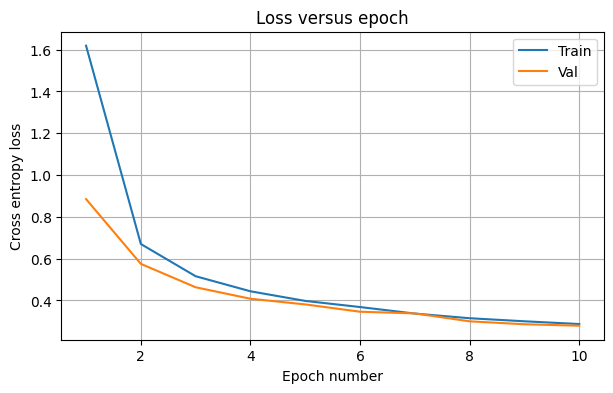

In [10]:
# now we visualize the training process, observe how the loss change over epochs
fig = plt.figure(figsize=(7,4))
plt.plot(np.arange(1,len(train_losses)+1), train_losses, label='Train')
plt.plot(np.arange(1,len(valid_losses)+1), valid_losses, label='Val')
plt.legend()
plt.ylabel('Cross entropy loss')
plt.xlabel('Epoch number')
plt.title('Loss versus epoch')
plt.grid()
plt.savefig('./Loss_versus_epoch.jpg', dpi=600,bbox_inches = 'tight') # Save the figure
plt.show()

Test the model performance on the testing set. The model performance is determined by evaluating its performance on the testing set. This is also the homework of week 1.

In [11]:
def acc_np(y_true, y_pred):
  y_true = np.array(y_true)
  y_true = y_true.squeeze()
  y_pred = np.argmax(y_pred, axis=1) # get the predicted class
  acc = (y_true == y_pred).sum()/len(y_true) * 100
  acc = round(acc,2)
  return acc

In [12]:
y_col = "label"
X_col = list(test_df.columns[1:])
test_set = MNISTDataset(test_df, X_col, y_col)
# It should be noted that we don't need shuffle in the testing, and the drop_last must be set as False
# so that every testing sample will be used.
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)
model.eval() # Set the model to evaluation mode
total_test_preds = []
total_test_truth = []
with torch.no_grad():
    for test_batch in test_loader:
        test_X, test_y = test_batch
        test_X = test_X.to(device)
        test_y = test_y.to(device)
        test_preds = model(test_X)

        total_test_preds = total_test_preds + list(test_preds.cpu().numpy())
        total_test_truth = total_test_truth + list(test_y.cpu().numpy())
# see the length of the preds and truth
print(len(total_test_preds), len(total_test_truth))
print(f'Accuracy on the testing set is {acc_np(total_test_truth, total_test_preds)}%')


10000 10000
Accuracy on the testing set is 92.45%


# Step 5. Assignments
Please finish the following assignments and save the output log. Then, you can upload the saved jupyter notebook to canvas.

## Assignment 1: Play with avg_pool2d and LeakyReLU
avg_pool2d: We have [F.avg_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html#torch.nn.functional.avg_pool2d) and [nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d) in the Pytorch. Please try to replace `nn.MaxPool2d` and `F.max_pool2d` with the them. Then, you should rerun the code and tell me the final accuracy on the testing set. The definition of your model should also be copied to the following code cell.  (3 points)

In [13]:
# avg_pool2d
# please copy your definition of the model that uses average pooling here, and write its testing accuracy in the comment.
# Testing accuracy: ???
class CNN(nn.Module):
    # Replace the definition with yours
    pass

LeakyReLU: The [nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU) and [F.leaky_relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.leaky_relu.html#torch.nn.functional.leaky_relu) can be found in Pytorch. Please replace the ReLU activation with them. Then, you should rerun the code and tell me the final accuracy on the testing set. The definition of your model should also be copied to the following code cell. (3 points)

In [14]:
# LeakyReLU
# please copy your definition of the model that uses LeakyReLU here, and write its testing accuracy in the comment.
# Testing accuracy: ???
class CNN(nn.Module):
    # Replace the definition with yours
    pass

## Assignment 1: Build a model that has testing accuracy more than 95% (4 points)
Hints: You can adjust the hyper-parameters or improve your model architecture by using different pooling layers and activation functions. There are a lot of activation functions and pooling layers you can find in Pytorch. Don't be scared. CNN is very powerful, and you can easily achieve the goal by adjusting the hyper-parameters.

After you have achieved this goal, please copy your hyper-parameters and model definition to the following code cell. In addition, you should submit the `loss versus epoch` figure to the Canvas. The final testing accuracy should be reported in the comment.

In [15]:
# Build your model.
# please copy your definition of the model here, and write its testing accuracy in the comment.
# Testing accuracy: ???

# Define the hyper-parameters
out_channels = 32
kernel_size = 3
drop_out_rate = 0.1
batch_size = 512
epochs = 10
lr = 0.005 # learning rate

class CNN(nn.Module):
    # Replace the definition with yours
    pass